In [50]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
#import torch.cuda
import random
from itertools import chain as chain
from torch.distributions.multivariate_normal import MultivariateNormal

#conda activate base
cudaOn = True

In [70]:
#tepLoc = "C:/Users/Charlie/Desktop/TEP_Data/"
#tepTrain = tepLoc + "TEP_Faulty_Training.csv"
#tepTest = tepLoc + "TEP_Faulty_Testing.csv"
tepTrain = '/content/TEP_Faulty_Training.csv'
tepTest = '/content/TEP_Faulty_Testing.csv'

scaler = StandardScaler()

#data = pd.read_csv('c172_file_1.csv')
data = pd.read_csv(tepTrain)
dataTest = pd.read_csv(tepTest)
print(data)
#I should only be scaling the values that are double values, scaling fault number and other stuff just kinda fucks output
scaler.fit(data)
data = pd.DataFrame(scaler.transform(data))
dataTest = pd.DataFrame(scaler.transform(dataTest))


      Unnamed: 0  faultNumber  simulationRun  ...   xmv_9  xmv_10  xmv_11
0              1            1              1  ...  47.510  41.258  18.447
1              2            1              1  ...  47.427  41.359  17.194
2              3            1              1  ...  47.468  41.199  20.530
3              4            1              1  ...  47.658  41.643  18.089
4              5            1              1  ...  47.346  41.507  18.461
...          ...          ...            ...  ...     ...     ...     ...
5516        5517           12              1  ...  46.957  40.956  20.094
5517        5518           12              1  ...  46.687  41.324  19.960
5518        5519           12              1  ...  46.426  40.819  18.776
5519        5520           12              1  ...  46.273  41.153  18.022
5520        5521           12              1  ...     NaN     NaN     NaN

[5521 rows x 56 columns]


In [68]:
#data = data.drop('Unnamed: 0',axis=1)
data = data.drop('faultNumber',axis=1)
faultNumbersTest = dataTest.get('faultNumber')
#dataTest = dataTest.drop('Unnamed: 0',axis=1)
dataTest = dataTest.drop('faultNumber',axis=1)

print(faultNumbersTest)
#numVariables = 31
numVariables = 55

KeyError: ignored

In [55]:
def tep_testing_stepped(data,step_size):
    res = []
    ind = 0
    #print(int((len(data)/step_size)))
    for i in range(int((len(data)/step_size))):
        if ind + step_size < len(data):
            step = []
            for j in range(step_size):
              #print(data.iloc(0)[ind])#[ind])
              step.append(data.iloc(0)[ind])
              ind = ind + 1
            res.append(step)
    return res

t = tep_testing_stepped(dataTest,5)
#t = to_var(t)
#print(len(t[0][0]))

In [56]:
#Split and reshape the data set by step_size , use min-max or stanrdardlize method to rescale the data
def Splitting_dataset(data, step_size, scale=True, scaler_type=MinMaxScaler):
        l = len(data) 
        data = scaler_type().fit_transform(data)
        Xs = []
        Ys = []
        for i in range(0, (len(data) - step_size)):
            Xs.append(data[i:i+step_size])
            Ys.append(data[i:i+step_size])
        train_x, test_x, train_y, test_y = [np.array(x) for x in train_test_split(Xs, Ys)]
        assert train_x.shape[2] == test_x.shape[2] == (data.shape[1] if (type(data) == np.ndarray) else len(data))
        return  (train_x.shape[2], train_x, train_y, test_x, test_y)
    
def get_batch(x, batch_size):
    """Made with taking test_x or XX as input"""
    t = 0
    while t >= 0:
        x_mod = len(x) % batch_size
        start = random.random() * (len(x)-x_mod)
        start = int(start)
        if start + batch_size < len(x):
            t = t-1
    batch = x[start:(start+batch_size)]
    #print(batch.shape)
    return batch

def to_var(x):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)

def loss_fn(recon_x, x, mu, logvar):
        BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
    
        # see Appendix B from VAE paper:
        # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
        # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
        KLD = -0.5 * torch.sum(1 + logvar - mu**2 -  logvar.exp())
        return BCE + KLD
    


In [57]:
class VAE(nn.Module):
    def __init__(self, image_size=784, h_dim=27, z_dim=31, n_flow_steps=1):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(image_size, h_dim),
            nn.LeakyReLU(0.1),
            nn.Linear(h_dim, z_dim*2) #is it saying its getting a mu and a var for each z dim out?
            
            #how can I represent the encoder as a distribution acting as the prior?
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, h_dim),
            nn.ReLU(),
            nn.Linear(h_dim, image_size),
            nn.Sigmoid()
        )
    
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_() 
        esp = to_var(torch.randn(*mu.size()))
        z = mu + std * esp
        return z
    
    def forward(self, x):
        h = self.encoder(x)
        mu, logvar = torch.chunk(h, 2, dim=1)
        #print(mu.shape)
        #print(logvar.shape)
        z = self.reparameterize(mu, logvar)
        #print(z.shape)
        #z = z.float()
        z = model(z)
        #print(z)
        tensorZ = z[0]#torch.tensor(z[0])
        #print(tensorZ.shape)
        #print(z[0])
        return self.decoder(tensorZ), mu, logvar
    

class stacked_NVP(nn.Module):
    def __init__(self, d, k, hidden, n):
        super().__init__()
        self.bijectors = nn.ModuleList([
            R_NVP(d, k, hidden=hidden) for _ in range(n)
        ])
        self.flips = [True if i%2 else False for i in range(n)]
        
    def forward(self, x):
        log_jacobs = []

        for bijector, f in zip(self.bijectors, self.flips):
            x, log_pz, lj = bijector(x, flip=f)
            log_jacobs.append(lj)
        
        return x, log_pz, sum(log_jacobs)
    
    def inverse(self, z):
        for bijector, f in zip(reversed(self.bijectors), reversed(self.flips)):
            z = bijector.inverse(z, flip=f)
        return z
    
class R_NVP(nn.Module):
    def __init__(self, d, k, hidden):
        super().__init__()
        self.d, self.k = d, k
        self.sig_net = nn.Sequential(
                    nn.Linear(k, hidden),
                    nn.LeakyReLU(),
                    nn.Linear(hidden, d - k))

        self.mu_net = nn.Sequential(
                    nn.Linear(k, hidden),
                    nn.LeakyReLU(),
                    nn.Linear(hidden, d - k))

    def forward(self, x, flip=False):
        x1, x2 = x[:, :self.k], x[:, self.k:] 

        if flip:
            x2, x1 = x1, x2
        
        # forward
        sig = self.sig_net(x1)
        z1, z2 = x1, x2 * torch.exp(sig) + self.mu_net(x1)
        
        if flip:
            z2, z1 = z1, z2
        
        z_hat = torch.cat([z1, z2], dim=-1)

        log_pz = base_dist.log_prob(z_hat)
        log_jacob = sig.sum(-1)
        
        return z_hat, log_pz, log_jacob
    
    def inverse(self, Z, flip=False):
        z1, z2 = Z[:, :self.k], Z[:, self.k:] 
        
        if flip:
            z2, z1 = z1, z2
        
        x1 = z1
        x2 = (z2 - self.mu_net(z1)) * torch.exp(-self.sig_net(z1))
        
        if flip:
            x2, x1 = x1, x2
        return torch.cat([x1, x2], -1)

In [58]:
step_size = 5
batch = 512
index_step_length = numVariables
epochs = 10

d = 2
k = 1

base_mu, base_cov = torch.zeros(2), torch.eye(2)

base_mu = to_var(base_mu.double())
base_cov = to_var(base_cov.double())

base_dist = MultivariateNormal(base_mu, base_cov)
#---------------------------------------------------------------------------------------------------------------------------------
labels, X, Y, XX, YY = Splitting_dataset(data, step_size)
#XX.cuda()
demo = VAE(index_step_length,h_dim=7,z_dim=2)
model = stacked_NVP(d, k, hidden=512,n=3)
demo.double()
model.double()
    
#next set of tests should be with n=3, last set was with n=1
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-3)
optimizer2 = torch.optim.RMSprop(demo.parameters(), lr=1e-3)

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.999)

if torch.cuda.is_available() & cudaOn:
    demo.cuda()
    print("demo done")
    model.cuda()
    print("model done")

demo done
model done


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch[1/10] Loss: 0.337
Epoch[1/10] Loss: 0.341
Epoch[1/10] Loss: 0.335
Epoch[1/10] Loss: 0.334
Epoch[1/10] Loss: 0.334
Epoch[2/10] Loss: 0.337
Epoch[2/10] Loss: 0.349
Epoch[2/10] Loss: 0.339
Epoch[2/10] Loss: 0.345
Epoch[2/10] Loss: 0.340
Epoch[3/10] Loss: 0.337
Epoch[3/10] Loss: 0.335
Epoch[3/10] Loss: 0.334
Epoch[3/10] Loss: 0.456
Epoch[3/10] Loss: 0.336
Epoch[4/10] Loss: 0.337
Epoch[4/10] Loss: 0.337
Epoch[4/10] Loss: 0.432
Epoch[4/10] Loss: 0.341
Epoch[4/10] Loss: 0.337
Epoch[5/10] Loss: 0.337
Epoch[5/10] Loss: 0.340
Epoch[5/10] Loss: 0.340
Epoch[5/10] Loss: 0.337
Epoch[5/10] Loss: 0.336
Epoch[6/10] Loss: 0.336
Epoch[6/10] Loss: 0.339
Epoch[6/10] Loss: 0.338
Epoch[6/10] Loss: 0.336
Epoch[6/10] Loss: 0.336
Epoch[7/10] Loss: 0.341
Epoch[7/10] Loss: 0.336
Epoch[7/10] Loss: 0.336
Epoch[7/10] Loss: 0.342
Epoch[7/10] Loss: 0.330
Epoch[8/10] Loss: 0.335
Epoch[8/10] Loss: 0.330
Epoch[8/10] Loss: 0.338
Epoch[8/10] Loss: 0.336
Epoch[8/10] Loss: 0.337
Epoch[9/10] Loss: 0.413
Epoch[9/10] Loss

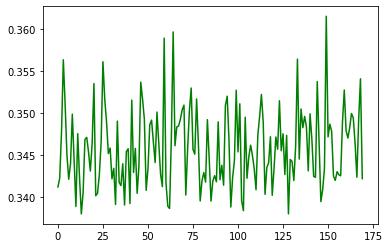

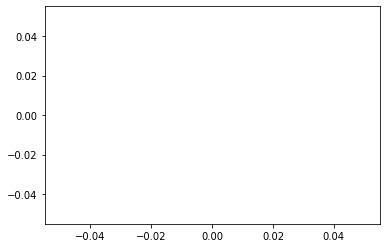

In [60]:
idx = 0

anomaly_history = []
loss_history = []
avgSum = 0
avgCount = 0

for epoch in range(epochs):
    b = get_batch(X,batch)
    #print(range(batch))
    for i in range(batch):
        #localX = torch.tensor(b[i].cuda())
        localX = to_var(torch.tensor(b[i]))
        recon, mu, logvar = demo(localX)
        loss = loss_fn(recon, localX, mu, logvar) #doing kl-divergence loss correctly
        """This bound (kl loss) provides a unified objective function for 
        op-timization of both the parameters θ and φ of the model and variational approximation, respectively."""
        optimizer.zero_grad()
        optimizer2.zero_grad()
        loss.backward()
        optimizer.step()
        optimizer2.step()
        scheduler.step()
        idx = idx + 1

        avgSum = avgSum + torch.mean(loss/batch)
        avgCount = avgCount + 1
        anomaly_score = torch.mean(localX/recon)

        if idx%30 == 0:
            loss_history.append(avgSum/avgCount)
            anomaly_history.append(anomaly_score)
            avgSum = 0
            avgCount = 0

        if idx%100 == 0:
            print("Epoch[{}/{}] Loss: {:.3f}".format(epoch+1, epochs, loss.data.item()/batch))
            
p1 = plt.figure()
plt.plot(loss_history,'g-',label='h 10,z 2')


step_start = 0
anomalies = []
county = 0
#print(type(XX))
#print(len(XX))
#print(XX.shape)
for step in t:
  step = to_var(torch.tensor(step))
  if step_start + step_size < len(XX):
      #step = torch.tensor(XX[step_start:step_start+step_size])[0]
      recon,_,_ = demo(step)
      anom = torch.mean(step/recon)
      if county%100 == 0:
        print("step: " + str(step))
        print("recon: " + str(recon))
        print(anom)
      anomalies.append(anom)
      step_start = step_start + 1
      county = county + 1
        
p3 = plt.figure()
plt.plot(anomalies, 'g-')